**DATABASE SETUP**

In [1]:
from pymongo import MongoClient

mongo_connection = 'mongodb://localhost:27017/'
mongo_database = 'deeplecture'
mongo_collection = 'corrected_all_text_data'

client = MongoClient(mongo_connection)
db = client[mongo_database]
collection_complete = db[mongo_collection]


**DATABASE FUNCTIONS AND FILTERS**

In [2]:
def fetch_documents():
    """
    Fetch all documents from the original collection.

    Returns:
    - list: List of documents from the original collection.
    """
    return list(collection_complete.find())

def insert_documents(collection_new, documents):
    """
    Insert documents into the a collection.

    Parameters:
    - collection_new (mongosb collection): New collection to create
    - documents (list): List of documents.
    """
    if documents:
        collection_new.insert_many(documents)

def filter_by_metadata(initial_query: dict, metadata: dict):
    """
    Filters documents by metadata on top of an existing query.
    
    :param initial_query: Initial query dictionary
    :param metadata: Dictionary containing metadata to filter on
    :return: List of documents that match the combined query
    """
    combined_query = initial_query.copy()
    for key, value in metadata.items():
        combined_query[f"metadata.{key}"] = value
    results = collection_complete.find(combined_query)
    return list(results)

def filter_by_terms(query: dict, terms: list):
    """
    Filters documents by searching for terms in the text on top of an existing query.
    
    :param query: Initial query dictionary
    :param terms: List of terms to search for in the text of documents
    :return: List of documents that contain any of the terms
    """
    terms_query = {'$or': [{'text': {'$regex': term, '$options': 'i'}} for term in terms]}
    combined_query = {**query, **{'$and': [terms_query]}}
    results = collection_complete.find(combined_query)
    return list(results)

def filter_by_terms_together(query: dict, terms: list):
    """
    Filters documents by searching for documents where all specified terms appear together in the text on top of an existing query.
    
    :param query: Initial query dictionary
    :param terms: List of terms that should appear together in the text of documents
    :return: List of documents that contain all of the terms together
    """
    if not terms or len(terms) < 2:
        raise ValueError("Please provide at least two terms to search for.")

    combined_regex = "(?=.*" + ")(?=.*".join(terms) + ")"
    combined_query = {**query, **{'text': {'$regex': combined_regex, '$options': 'i'}}}
    results = collection_complete.find(combined_query)
    return list(results)

def filter_and_count_by_metadata_field(query: dict, metadata_field: str):
    """
    Aggregates documents by a specified metadata field and counts the number of documents in each category.
    
    :param query: Initial query dictionary to filter the documents
    :param metadata_field: The metadata field name to group by (e.g., 'metadata.periodo')
    :return: Dictionary with metadata field values as keys and counts as values
    """
    pipeline = [
        {'$match': query},
        {
            '$group': {
                '_id': f'$metadata.{metadata_field}',
                'count': {'$sum': 1}
            }
        },
        {
            '$sort': {'_id': 1}
        }
    ]
    
    results = collection_complete.aggregate(pipeline)
    
    field_counts = {result['_id']: result['count'] for result in results}
    return field_counts


**DATABASE FILTERS TEST**

In [ ]:
initial_query = {}

# First filter by metadata
metadata_filter = {'autor': 'varios', 'anyo': '1778'}
documents_by_metadata = filter_by_metadata(initial_query, metadata_filter)
print(f"Number of documents filtered by metadata: {len(documents_by_metadata)}")

# Then filter the above result by terms
terms_filter = ['agricultura', 'economia']
documents_by_terms = filter_by_terms(initial_query, terms_filter)
print(f"Number of documents filtered by metadata and then by terms: {len(documents_by_terms)}")

# Finally filter the above result by terms together
terms_together_filter = ['historia', 'ciencias']
documents_by_terms_together = filter_by_terms_together(initial_query, terms_together_filter)
print(f"Number of documents filtered by metadata, then by terms, and then terms together: {len(documents_by_terms_together)}")

**PLOTTING FUNCTIONS**

In [3]:
import matplotlib.pyplot as plt

# Aggregating and Plotting
def plot_documents_by_metadata_field(query: dict, metadata_field: str):
    """
    Filters and plots the number of documents by any metadata field.
    
    :param query: Initial query dictionary to filter the documents
    :param metadata_field: The metadata field name to group by (e.g., 'periodo')
    """
    # Get counts of documents by the specified metadata field
    field_counts = filter_and_count_by_metadata_field(query, metadata_field)
    
    # Prepare data for plotting
    categories = list(field_counts.keys())
    counts = list(field_counts.values())
    
    # Plotting the line chart
    plt.figure(figsize=(10, 6))
    plt.plot(categories, counts, marker='o')

    plt.xlabel(metadata_field)
    plt.ylabel('Number of Documents')
    plt.title(f'Number of Documents by {metadata_field.capitalize()}')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()

**PLOTTING TEST**

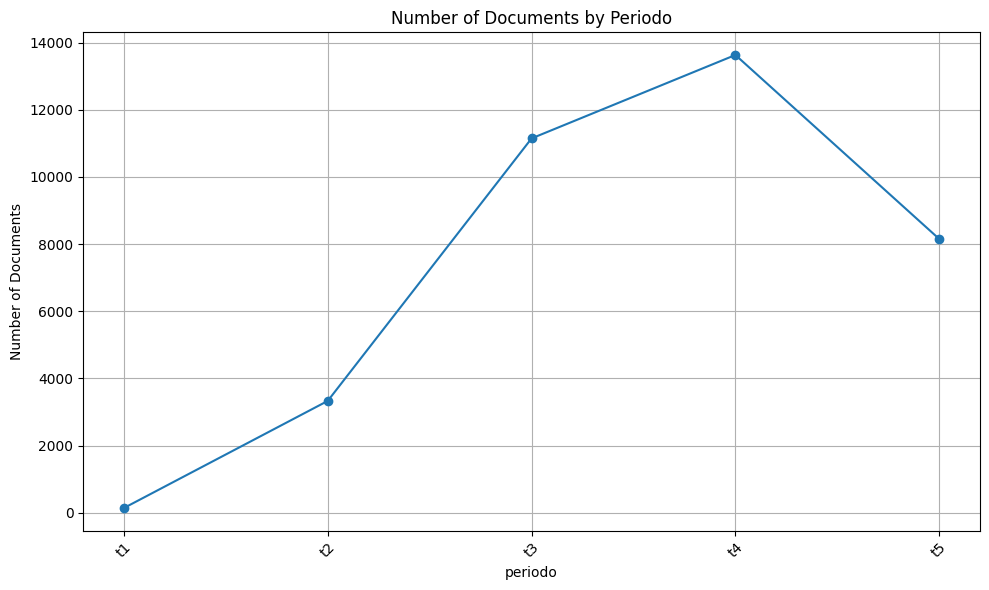

In [4]:
initial_query = {}  # You can modify this to filter documents further
metadata_field = 'periodo'  # Change this to any other metadata field you want to plot

# Plot documents by specified metadata field
plot_documents_by_metadata_field(initial_query, metadata_field)

**TEXT CLEANING FUNCTIONS**

**NOTE:** For lemmatization to work first do this `python -m spacy_spanish_lemmatizer download wiki` in your terminal (You only have to run it once)

In [13]:
import nltk
from nltk.corpus import stopwords
import string
import spacy
import spacy_spanish_lemmatizer
import unidecode
import time

nltk.download('punkt')
nltk.download('stopwords')

def tokenize(text):
    """
        Tokenize the input text using NLTK's word_tokenize for the Spanish language.

        Parameters:
        - text (str): Input text.

        Returns:
        - list: List of tokens.
    """
    return nltk.word_tokenize(text, language='spanish')

def remove_accents(text):
    """
        Remove accents from characters in the text, keeping 'ñ' and 'Ñ' intact.

        Parameters:
        - text (str): Input text.

        Returns:
        - str: Text with accents removed.
    """
    return ''.join([char if char in ['ñ', 'Ñ'] else unidecode.unidecode(char) for char in text])


def remove_non_letters(text):
    """
        Remove non-letter characters from the text.

        Parameters:
        - text (str): Input text.

        Returns:
        - str: Text with non-letter characters removed.
    """
    return ''.join(char for char in text if char.isalpha() or char.isspace() or char == 'ñ' or char == 'Ñ')

def remove_stopwords(words):
    """
    Remove stopwords from a list of words and filter out words shorter than 3 letters,
    unless the word is punctuation.

    Parameters:
    - words (list): List of words.

    Returns:
    - str: Text with stopwords and short words removed.
    """
    # Get the stopwords
    stop_words = set(stopwords.words('spanish'))

    # Define a set of Spanish punctuation characters
    spanish_punctuation_set = set(string.punctuation + '¡¿')

    # Remove stopwords and words smaller than 3 letters but that are not punctuation
    filtered_words = [word for word in words
                      if word.lower() not in stop_words and (len(word) > 2 or word in spanish_punctuation_set)]

    # Join the filtered words back into a string
    filtered_text = ' '.join(filtered_words)

    return filtered_text

def clean_text(text, remove_non_letters_flag=True):
    """
    Clean the input text by performing several preprocessing steps: 
    lowering case, tokenizing, removing stopwords, removing accents,
    and optionally removing non-letter characters.

    Parameters:
    - text (str): Input text.
    - remove_non_letters_flag (bool): Flag to indicate if non-letter characters should be removed.

    Returns:
    - str: Cleaned text.
    """
    text_lowercase = text.lower()
    # Tokenize the text
    tokenized_text = tokenize(text_lowercase)
    text_no_stopwords = remove_stopwords(tokenized_text)
    text_no_stopwords_filtered = remove_accents(text_no_stopwords)
    tokenized_text = tokenize(text_no_stopwords_filtered)
    text_no_stopwords_filtered = remove_stopwords(tokenized_text)
    if remove_non_letters_flag:
        text_no_stopwords_filtered = remove_non_letters(text_no_stopwords_filtered)
    return text_no_stopwords_filtered

def lemmatizer(text):
    """
    Lemmatize the input text using spaCy's Spanish lemmatizer.

    Parameters:
    - text (str): Input text.

    Returns:
    - list: List of lemmatized words.
    """
    # Load spanish lemmatizer
    nlp = spacy.load("es_core_news_md")

    nlp.max_length = 1500000  # Adjust this value according to your needs due to length of texts. It might cause memory issues in some systems

    nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

    # Process the neighborhood in the pipeline
    doc = nlp(text)

    # Create the lemmatized_text
    lemmatized_text = []
    for token in doc:
        lemmatized_text.append(token.lemma_)
    return lemmatized_text

def clean_and_lemmatize_documents(documents):
    """
    Clean and lemmatize text for each document.

    Parameters:
    - documents (list): List of documents from the original collection.

    Returns:
    - list: List of documents with cleaned and lemmatized text.
    """
    cleaned_documents = []
    start_time = time.time()  # Start timing

    for i, doc in enumerate(documents):
        text = doc.get('text', '')
        cleaned_text = clean_text(text)
        lemmatized_text = lemmatizer(cleaned_text)
        new_doc = doc.copy()
        new_doc['cleaned_text'] = lemmatized_text
        cleaned_documents.append(new_doc)

        if i % 1000 == 0 and i != 0:
            end_time = time.time()  # Check time after processing each 1000 documents
            elapsed_time = end_time - start_time
            print(f"{i} documents processed in {elapsed_time:.2f} seconds.")

    return cleaned_documents


[nltk_data] Downloading package punkt to /home/odrec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/odrec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**TEST CLEANING DOCUMENTS**

In [ ]:
mongo_new_collection = 'cleaned_text_data'
collection_new = db[mongo_new_collection]

# Fetch documents from the original collection
documents = fetch_documents()

# Clean and lemmatize text for each document
cleaned_documents = clean_and_lemmatize_documents(documents)

# Insert cleaned documents into the new collection
insert_cleaned_documents(collection_new, cleaned_documents)

print("Completed: Cleaned and lemmatized documents have been inserted into the new collection.")